## Part 1. Initialization

In [1]:
# 1 Initialization
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.colors as c
import os
import mpmath
from astropy.io import fits
from datetime import datetime
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
import sympy as sp

## Part 2. Defining the Nebula

In [2]:
# 2 Important Parameters
observingLatitudeDegrees = 24 # degrees, Observing latitude - Default : 25
viewLength = 6e17 # cm, Length of the display box - Default : 6e17
distanceLY = 8000 # ly, Distance to the lebula - Default : 8000
resolution = 120 # Number of pixels of one side of the display - Default : 200
distance_steps = 1500 # Number of distance steps in the optical depth center array - Default : 3000
angle_steps = 1800 # Number of angle steps in the optical depth center array - Default : 1800
absorptionSteps_center = 10 # Number of steps between two adjacent elements of the spherical optical depth array - Default : 10
absorptionSteps = 10 # Number of steps between two adjacent elements in the cubical optical depth array - Default : 5

In [3]:
# 3 Nebula Shape Parameters
Rin = 2e16 # cm, Inner cavity radius - Default : 1e16
power = 2 # Density inverse relation to radius - Default : 2
density_enhancement = 10 # Density enhancement factor in the lobe walls - Default : 7
edge_thickness = 0.1 # The thickness factor of the edge relative to the size of the lobe - Default : 0.12
eccentricity = 0.88 # Eccentricity of the conic shaped lobe - Default : 0.85
focus_shift = viewLength * 0.015 # Coordinate of the conic section edge - Default : 0
focus_shift_2 = -focus_shift - viewLength * 0.00  # Coordinate of the inner conic section edge - Default : 0
focus = viewLength * 0.033 - focus_shift # cm, Location of the focus of the conic shaped lobe - Default : -viewLength / 100
directrix = -(focus + focus_shift) / eccentricity - focus_shift # cm, Location of the directrix of the conic shaped lobe - Default : -viewLength / 10.9
ansa_eccentricity = 0.4 # Eccentricity of the ansa - Default : 0.85
ansa_focus_shift = -viewLength * 0.12 # Location of the base of the ansa - Default : -viewLength * 0.11
ansa_focus = viewLength * 0.04 - ansa_focus_shift # cm, Location of the ansa focus - Default : viewLength / 4
ansa_directrix = -(ansa_focus + ansa_focus_shift) / ansa_eccentricity - ansa_focus_shift # cm, Location of the ansa directrix - Default : viewLength / 4
cutoff_distance = viewLength * 0.2 # cm, Cutoff from the conic region to the linear region in the lobes
outer_slope = 0.35 # cm, Slope of the linear region boundary

In [4]:
# 4 Nebula Content Parameters
Mdot_Solar_Mass = 8e-5 # solar masses, Mass loss rate of all molecules - Default : 1e-5
Mdot = Mdot_Solar_Mass * 2e33 / (365 * 24 * 60 * 60) # g / seconds, Mass loss rate of all molecules
Mdot_Lat_Dependence = 1.2 # Mass loss rate doubles in the plane, and accordingly quarters in the axis
particle_radius = 1e-5 # cm, Radius of the dust particles - Default : 1e-5 / smaller
wavelength = 5e-5 # cm, Wavelength used by the observing telescope - Default : 5e-5
albedo = 0.38 # Albedo of the dust particles
scattering_effective_crosssection = (np.pi * particle_radius ** 2) * 2 * np.pi * (particle_radius / (wavelength)) # Per grain per cm^2, Effective scattering cross section of the particles
dust_to_gas = 1 / 200 # Dust to gas ratio - Default : 1 / 200
grain_mass = 1.3e-14 # grams, Mass of the individual grain - Default : 1.3e-14
asymmetry_constant = 0.5 # The scattering asymmetry constant (overwritten in block # 20) - Default : 0.5

In [5]:
# 5 Pre-compute Important Numbers
observingLatitude = np.pi * (observingLatitudeDegrees / 180) # radians, Observing latitude 
sin = np.sin(observingLatitude) # precompute the trigs of the observer
cos = np.cos(observingLatitude)
viewSize = viewLength / 2 # cm, Half the size of the picture
angularSize = viewSize / (distanceLY / 2.18e-13) # arcseconds, Size of the nebula in angular units
FD = focus - directrix
center = focus + FD * eccentricity ** 2 / (1 - eccentricity ** 2)
focus_2 = center - (center - focus) * (1 - edge_thickness) - (focus + focus_shift) * edge_thickness / (1 - eccentricity) + focus_shift - focus_shift_2
directrix_2 = center - (center - directrix) * (1 - edge_thickness) - (focus + focus_shift) * edge_thickness / (1 - eccentricity) + focus_shift - focus_shift_2

In [6]:
# 6 Logistic functions
def norm(x):
    return np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2)
  # norm(): returns the norm of a given vector x (the vector is in the form of np.array([x, y, z]))

def vector_angle(v1, v2):
    norm1 = norm(v1)
    norm2 = norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    else:
        factor = np.dot(v1, v2) / (norm1 * norm2)
        if factor > 1:
            return 0
        elif factor < -1:
            return np.pi
        else:
            return np.arccos(factor)
    # vector_angle(): returns the angle between two cartesian vectors

def spherical_to_cartesian(r):
    sin_cur = np.sin(r[1])
    return np.array([r[0] * sin_cur * np.cos(r[2]), r[0] * sin_cur * np.sin(r[2]), r[0] * np.cos(r[1])])
  # spherical_to_cartesian(): returns the cartesian representation of the given spherical vector r
  # the cartesian vector x is defined in the refernce frame of nebula, not the observer

def cartesian_to_spherical(x):
    norm = np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2) # pre compute the norm of the vector
    if norm == 0:
        return np.array([0, 0, 0])
    elif x[0] == 0:
        return np.array([norm, np.arccos(x[2] / norm), np.pi / 2])
    else:
        return np.array([norm, np.arccos(x[2] / norm), np.arctan(x[1] / x[0])])
    # cartesian_to_spherical(): returns the spherical representation of the cartesian vector x
    # the cartesian vector x is defined in the reference frame of nebula, not the observer

In [7]:
# 7 Scattering Phase Function
def phase_function(angle): # Henyey-Greenstein
    return 1 / (4 * np.pi) * (1 - asymmetry_constant ** 2) / ((1 + asymmetry_constant ** 2 - 2 * asymmetry_constant * np.cos(angle)) ** (3 / 2))

In [8]:
# 8 Detailed Shape of the Nebula
x, y = sp.symbols('x y')
eq1 = sp.Eq(((cutoff_distance ** 2 + focus ** 2 - 2 * x * focus) ** (1 / 2) / (x - directrix)) - eccentricity, 0) # Outer conic section formula
eq2 = sp.Eq(x ** 2 + y ** 2 - cutoff_distance ** 2, 0) # The point distance to the center has to be equal to cutoff_distance
sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
x_cut = np.abs(sol[1][0]) # x coordinate of the point
y_cut = np.abs(sol[1][1]) # y coordinate of the point

x, y = sp.symbols('x y')
eq1 = sp.Eq((((cutoff_distance * (1 - edge_thickness)) ** 2 + focus_2 ** 2 - 2 * x * focus_2) ** (1 / 2) / (x - directrix_2)) - eccentricity, 0) # Inner conic section formula
eq2 = sp.Eq(x ** 2 + y ** 2 - (cutoff_distance * (1 - edge_thickness / 1.25)) ** 2, 0) # The point distance to the center has to be equal to cutoff_distance
sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
x_cut_2 = np.abs(sol[1][0]) # x coordinate of the point
y_cut_2 = np.abs(sol[1][1]) # y coordinate of the point

y_intercept = y_cut + outer_slope * x_cut # Calculates the y-intercept of the outer linear boundary
y_intercept_2 = y_cut_2 + outer_slope * x_cut_2 # Calculates the y-intercept of the inner linear boundary

def lobe(sin_lat, distance): #both must be positive absolute values
    if sin_lat < 0:
        distance = distance * 0.9
    sin_lat = np.abs(sin_lat)
    if distance < cutoff_distance: # Conic region
        pf = np.sqrt(distance ** 2 + focus ** 2 - 2 * distance * focus * sin_lat) # law of cosines
        pd = distance * sin_lat - directrix
        if np.abs(pf / pd) < eccentricity:
            pf_2 = np.sqrt(distance ** 2 + focus_2 ** 2 - 2 * distance * focus_2 * sin_lat) # law of cosines
            pd_2 = distance * sin_lat - directrix_2
            if np.abs(pf_2 / pd_2) < eccentricity:
                return 1
            return 2
        else:
            return 0
    else: # Linear region
        x = distance * sin_lat
        y = distance * (1 - sin_lat ** 2) ** (1 / 2)
        if y <= y_intercept - x * outer_slope:
            if y <= y_intercept_2 - x * outer_slope:
                return 1
            return 2
    
def ansa(sin_lat, distance):
    pf_ansa = np.sqrt(distance ** 2 + ansa_focus ** 2 - 2 * distance * ansa_focus * sin_lat) # law of cosines
    pd_ansa = distance * sin_lat - ansa_directrix
    if pd_ansa == 0:
        return 0
    parabola_factor_ansa = np.abs(pf_ansa / pd_ansa)
    if parabola_factor_ansa < ansa_eccentricity:
        return 1
    else:
        return 0

def density(latitude, distance): # The number density of the dust particles
    
    if distance < Rin / 2:
        return 0
    
    sin_lat = np.abs(np.sin(latitude))
    sin_lat_squared = sin_lat ** 2
    cos_lat_squared = 1 - sin_lat_squared
    lat = np.abs(latitude / np.pi * 2)
    
    Mdot_factor = Mdot_Lat_Dependence / np.sqrt((1 / Mdot_Lat_Dependence ** 2) * cos_lat_squared + Mdot_Lat_Dependence ** 4 * sin_lat_squared)
    
    if ansa(sin_lat, distance) == 1: # The ansa region
        velocity = 1.8e6 # cm/s, Outflow velocity in this region - Default : 5e6
        dr_cur = viewLength / 30 # cm, Width/Sharpness of the cutoff - Default : viewLength / 30
        R_cur = viewLength / 3 # cm, Cutoff radius - Default : viewLength / 3
        return Mdot_factor * (dust_to_gas * Mdot / grain_mass) / (4 * np.pi * (1e17 ** power) * velocity)
    
    elif lat >= 85 / 90 or lat >= 80 / 90 and distance <= ansa_focus:
        velocity = 7.5e7 # cm/s - Default : 2e7
        R_cur = viewLength * 0.5 # cm - Default : viewLength / 3
        dr_cur = viewLength / 30
        
    elif lobe(sin_lat, distance) == 1: # The lobe region
        # sin_lat_squared = sin_lat ** 2 # Square of the sine of the latitude
        # velocity_high = 7.5e7 # cm/s, Highest possible outflow velocity in the lobes - Default : 7.5e7
        # velocity_low = 2e7 # cm/s, Lowest possible outflow velocity in the lobes - Default : 2e7
        # velocity = velocity_high * velocity_low / np.sqrt(velocity_low ** 2 * sin_lat_squared + velocity_high ** 2 * (1 - sin_lat_squared)) # cm/s
        velocity = 5e7 # cm/s - Default : 7.5e7
        dr_cur = viewLength / 30 # cm - Default : viewLength / 30
        R_cur = viewLength / 3 # cm, Cutoff radius - Default : viewLength / 1.6

    elif lobe(sin_lat, distance) == 2: # The lobe walls region
        velocity = 2e7 / density_enhancement # cm/s
        dr_cur = viewLength / 200 # cm - Default : viewLength / 30
        R_cur = viewLength * 0.35
        if distance >= viewLength / 10:
            velocity = 2e7 / density_enhancement * ((viewLength * 0.1 / distance) ** 2)
    
    else: # The disk region
        sin_lat_squared = sin_lat ** 2 # Square of the sine of the latitude
        velocity_high = 5e5 # cm/s, Highest possible outflow velocity in the disk - Default : 6e6
        velocity_low = 5e5 # cm/s, Lowest possible outflow velocity in the disk - Default : 3e6
        velocity = velocity_high * velocity_low / np.sqrt(velocity_low ** 2 * sin_lat_squared + velocity_high ** 2 * (1 - sin_lat_squared)) # cm/s
        dr_cur = viewLength * 0.025 # cm - Default : viewLength / 50
        R_cur = 1e17 # cm - Default : 1000 years * velocity
        
    cutoff_outer = 0.5 * (1 - np.tanh((distance - R_cur) / dr_cur))
    cutoff_inner = 0.5 * (1 - np.tanh((Rin - distance) / (Rin / 10)))
    
    return Mdot_factor * (dust_to_gas * Mdot / grain_mass) * (cutoff_outer * cutoff_inner) / (4 * np.pi * (distance ** power) * velocity)

def density_cartesian(x):
    spherical = cartesian_to_spherical(x) # x in spherical coordinates
    return density(np.pi / 2 - spherical[1], spherical[0])

In [9]:
# 9 Density Display Function
@np.vectorize
def density_map(x, y):
    return density_cartesian(np.array([0, y, -x])) ** (1 / float(5))
# Density display, density scales by the power of 1/5

# Computing the density map
side = np.linspace(-viewSize, viewSize, 2 * resolution + 1)
x,y = np.meshgrid(side, side)
Value = density_map(x, y)

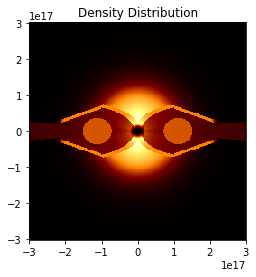

In [10]:
# 10 Density Display
plt.title("Density Distribution")
plt.pcolormesh(x, y, Value, cmap = 'afmhot', shading = 'auto')
# plt.annotate("Axis of Symmetry", xy = (viewLength / 20, -viewLength / 4), color = 'red')
# plt.axhline(y = 0, color = 'red', linestyle = '-')
# plt.annotate("Central Star", xy = (-viewLength / 20, viewLength / 4), color = 'blue')
# plt.plot([0], [0], marker = "x", markersize = 20, color = "blue")
plt.gca().set_aspect('equal')
# plt.axis('on')
# plt.show()

## Part 3. Computing The Optical Depth Arrays

In [11]:
# 11 Array Coordinate - Skyplane Coordinate Translations
def coord_to_index(x, y): 
    # coord_to_index(): Returns the array index i given the skyplane coordinates x, y in cm 
    return int(int(((x / viewSize) + 1) * (resolution / 2)) + int((y / viewSize) * (resolution / 2)) * (resolution + 1))
def index_to_x(i):
    # index_to_x(): Returns the skyplane coordinate x given the array index i
    return (int(i % (resolution + 1)) / (resolution / 2) - 1) * viewSize
def index_to_y(i):
    # index_to_y(): Returns the skyplane coordinate y given the array index i
    return (int(i / (resolution + 1)) / (resolution / 2)) * viewSize

In [12]:
# 12 Define Spherical Optical Depth Integration Function
def optical_depth_center_progression(latitude, distance):
    # optical_depth_center_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density(latitude, distance + i * (viewSize / (distance_steps * absorptionSteps_center)))
        sum += add # add the non constant density
        i += 1 / absorptionSteps_center
    sum = scattering_effective_crosssection * sum * (2 * viewSize / (distance_steps * absorptionSteps_center))
    # now multiply the constants of the integrand
    return sum / albedo # divide the albedo for the total extinction crosssection

In [13]:
# 13 Spherical Optical Depth Array
# Define the spherical optical depth array
# i from 0 to distance_steps, represents distance from 0 to 2*viewSize
# j from 0 to pi/2, represents the latitude
i, j = distance_steps + 1, angle_steps + 1
optical_depth_center_array = [[0 for x in range(i)] for y in range(j)]

In [14]:
# 14 Computing The Spherical Optical Depth Array
for i in range(0, angle_steps):
    for j in range(0, distance_steps):
        # For each angle, accumulatively compute the optical depth
        add = optical_depth_center_progression(i * np.pi / (2 * angle_steps), j * (2 * viewSize / distance_steps))
        optical_depth_center_array[i][j] = optical_depth_center_array[i][j - 1] + add

In [15]:
# 15 Define Cubical Optical Depth Integration Function
n = 2 * viewSize / resolution
def optical_depth_progression(x1, x2):
    # optical_depth_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density_cartesian(x1 + i * (x2 - x1))
        sum += add # add the non constant density
        i += 1 / absorptionSteps
    sum = scattering_effective_crosssection * sum * n / absorptionSteps # now multiply the constants of the integrand
    return sum / albedo # return the result

In [16]:
# 16 Cubical Optical Depth Array
# Define the cubical optical depth array
# j is the depth, "0" is the closest to the viewplane, "resolution" isthe deepest, resolution+1 steps in total
# i is the coordinate, is the x*(resolution+1)+y, minimum 0 (x minimum, y=0), maximum (resolution+1)*(resolution)-1 (top right corner)
# here x and y are pixel coordinates, from 0 to resolution
i, j = resolution + 1, (resolution + 1) * (int(resolution / 2) + 1)
optical_depth_array = [[0 for x in range(i)] for y in range(j)]

In [17]:
# 17 Computing The Cubical Optical Depth Array
r = (resolution + 1) * (int(resolution / 2) + 1) - 1
for i in range(0, r):
    for j in range(0, resolution):
        # For each coordinate, accumulate the optical depth along the line of sight
        x = index_to_x(i)
        y = index_to_y(i)
        
        add = optical_depth_progression(np.array([x * sin + (((resolution / 2) - j) / (resolution / 2) * viewSize) * cos, y, -x * cos + (((resolution / 2) - j) / (resolution / 2) * viewSize) * sin]), np.array([x * sin + (((resolution / 2) - (j - 1)) / (resolution / 2) * viewSize) * cos, y, -x * cos + (((resolution / 2) - (j - 1)) / (resolution / 2) * viewSize) * sin]))
        
        optical_depth_array[i][j] = optical_depth_array[i][j - 1] + add

## Part 4. Computing The Image

In [18]:
# 20 Defining the Optical Intensity Function
asymmetry_constant = 0.5
# The scattering asymmetry constant - Default : 0.5
# This can change with each recompute, without altering the array, mainly changing front/back ratio
scale_factor = 1.25 # The post-compute multiplier applied to the density/optical depths array

@np.vectorize
def intensity(x, y):
    sum = 0.0
    # total number of unit photons reaching the specified pixel
    i = coord_to_index(x, y)
    for j in range(0, resolution):
        cur = np.array([float(x * sin + (((resolution / 2) - j) / (resolution / 2) * viewSize) * cos), float(y), float(-x * cos + (((resolution / 2) - j) / (resolution / 2) * viewSize) * sin)])
        # current point (precise value stored in array)
        spherical = cartesian_to_spherical(cur) 
        # spherical of current point, to find the optical depth center
        o_d_center = scale_factor * optical_depth_center_array[np.abs(int((angle_steps / 90) * (90 - (180 * spherical[1] / np.pi))))][int(spherical[0] / (2 * viewSize) * distance_steps)]
        # optical depth from center
        o_d = scale_factor * optical_depth_array[i][j]
        # optical depth from point of interest to earth
        # the amount of photons from that point
        if x == 0 and y == 0 and j == resolution / 2: # point of interest is central star
            add = mpmath.exp(-scale_factor * optical_depth_array[coord_to_index(0, 0)][int(j)]) / ((viewLength / resolution) ** 2)
        else:
            add = (1 / (4 * np.pi * ((spherical[0]) ** 2))) * mpmath.exp(-o_d) * mpmath.exp(-o_d_center) * scale_factor * scattering_effective_crosssection * density(np.pi / 2 - spherical[1], spherical[0]) * (viewLength / resolution) * phase_function(vector_angle(np.array([cos, 0, sin]), cur))
        sum += add
    return sum

In [19]:
# 21 Computing The Top Half Image
side = np.linspace(-viewSize, viewSize, resolution + 1)
sideY = np.linspace(0, viewSize, int(resolution / 2) + 1)
x, y = np.meshgrid(side, sideY)
np.seterr(divide = 'ignore')
Value = intensity(x, y) # compute half of the intensity map

In [20]:
# 22 Generating Full Image from Half Image
@np.vectorize
def findValue(x, y):
    cur_x = int((x / (angularSize) + 1) * resolution / 2)
    cur_y = round(y * resolution / angularSize / 2)
    if y > 0:
        return float(Value[cur_y][cur_x])
    elif y == 0:
        return float(Value[0][cur_x])
    else:
        return float(Value[-cur_y][cur_x])

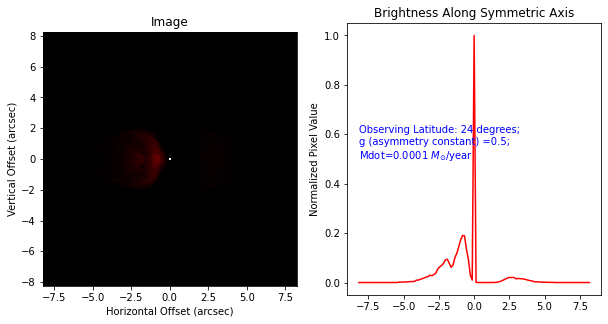

In [21]:
# 23 Plots
side_angular = np.linspace(-angularSize, angularSize, resolution + 1)
X, Y = np.meshgrid(side_angular, side_angular)
np.seterr(divide = 'ignore')
fullValues = findValue(X, Y)

f = plt.figure(figsize = (10, 5))
ax = f.add_subplot(121, aspect = 1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")
ax.pcolormesh(X, Y, fullValues, cmap = 'afmhot', shading = 'auto')
plt.gca().set_aspect('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angularSize, angularSize, resolution + 1)
y_array = fullValues[int(resolution / 2)]
normalizedYArray = y_array / np.max(np.nan_to_num(np.array(y_array, dtype = float)))
ax2.plot(x_array, normalizedYArray, color = 'red')
x_pos = (1 + np.min(normalizedYArray)) / 2
ax2.set_ylabel("Normalized Pixel Value")
plt.title("Brightness Along Symmetric Axis")

plt.annotate("Observing Latitude: " + str(observingLatitudeDegrees) + " degrees;\n" + "g (asymmetry constant) =" + str(asymmetry_constant) + ";\nMdot=" + str(round(Mdot_Solar_Mass * scale_factor, 6)) + " " + '$ M_{\odot}$' + "/year", xy = (-angularSize, x_pos), color = 'blue')

# ax3 = ax2.twinx()
# ax3.plot(x_array, np.nan_to_num(np.array(y_array, dtype = float)), color = 'blue', alpha = 0)
# ax3.set_ylabel("Absolute Intensity (Not currently Implemented)")

plt.show()

In [24]:
# 24 Saving Fits Files
modifiedValues = fullValues / np.amax(fullValues)
hdul = fits.PrimaryHDU(data = modifiedValues)
now = datetime.now()
t_string = now.strftime("%m_%d_%Y_%Hh%Mm%Ss")
m_string = now.strftime("%m_%Y")
if os.path.exists("Images/"+m_string) == False:
    os.makedirs("Images/"+m_string)
string = "Images/"+m_string+"/"+t_string+"_power_"+str(power)+"_multiplier_"+str(scale_factor)+"_1.fits"
hdul.writeto(string)

In [25]:
# 25 Image Convolution Kernel
kernel = Gaussian2DKernel(x_stddev = 3 / 500 * resolution, y_stddev = 3 / 500 * resolution)
astropy_conv = convolve(modifiedValues, kernel)

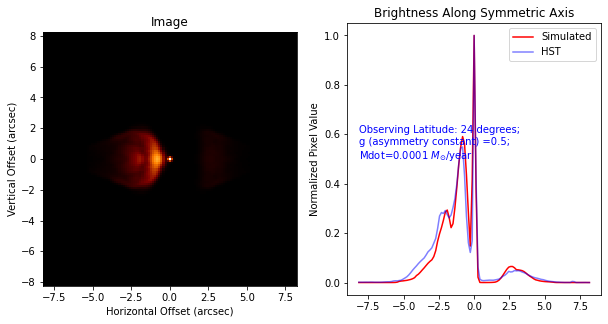

In [26]:
# 26 Plotting the Convoluted Image
f = plt.figure(figsize = (10, 5))
ax = f.add_subplot(121, aspect = 1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")
ax.pcolormesh(X, Y, astropy_conv, cmap = 'afmhot', shading = 'auto')
plt.gca().set_aspect('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angularSize, angularSize, resolution + 1)
y_array = astropy_conv[int(resolution / 2)]
normalizedYArray = y_array / np.max(np.nan_to_num(np.array(y_array, dtype = float)))
ax2.plot(x_array, normalizedYArray, color = 'red', label = 'Simulated')
x_pos = (1 + np.min(normalizedYArray)) / 2
ax2.set_ylabel("Normalized Pixel Value")
plt.title("Brightness Along Symmetric Axis")

hst = fits.open("hst_06761_02_wfpc2_f547m_wf_drz.fits")
hst_image = hst[1].data

x_hst = np.linspace(-100 *  0.1013 * np.sqrt(2) * np.cos(3 * np.pi / 180), 100 *  0.1013 * np.sqrt(2) * np.cos(3 * np.pi / 180), 201)
y_hst = [hst_image[980, 1459]]
for i in range(1, 101):
    y_hst.append(hst_image[980 - i, 1459 - i])
    y_hst.insert(0, hst_image[980 + i, 1459 + i])

y_hst_scaled = np.interp(x_array, x_hst, y_hst)
normalizedYHST = y_hst_scaled / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
ax2.plot(x_array, normalizedYHST, color = 'blue', alpha = 0.5, label = 'HST')

plt.annotate("Observing Latitude: " + str(observingLatitudeDegrees) + " degrees;\n" + "g (asymmetry constant) =" + str(asymmetry_constant) + ";\nMdot=" + str(round(Mdot_Solar_Mass * scale_factor, 6)) + " " + '$ M_{\odot}$' + "/year", xy = (-angularSize, x_pos), color = 'blue')

# ax3 = ax2.twinx()
# ax3.plot(x_array, np.nan_to_num(np.array(y_array, dtype = float)), color = 'blue', alpha = 0)
# ax3.set_ylabel("Absolute Intensity (Not currently Implemented)")

plt.legend()
plt.show()

In [27]:
# 27 Saving Convoluted Files
hdul = fits.PrimaryHDU(data = astropy_conv)
string = "Images/" + m_string + "/" + t_string + "_power_" + str(power) + "_multiplier_" + str(scale_factor) + "_convolved.fits"
hdul.writeto(string, overwrite = True)

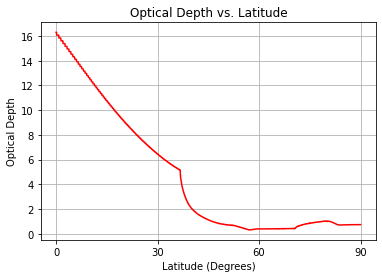

In [28]:
# 28 Plotting Central Optical Depth
x_odc = np.linspace(0, 90, 1800)
y_odc = np.array([])
x = [0, 30, 60, 90]
for i in range(0, 1800):
    y_odc = np.append(y_odc, optical_depth_center_array[i][999])
plt.plot(x_odc, y_odc, color = 'red')
plt.xticks(ticks = x)
plt.title("Optical Depth vs. Latitude")
plt.xlabel("Latitude (Degrees)")
plt.ylabel("Optical Depth")
plt.grid()
plt.show()

In [29]:
# 29 Calculating Total Mass
total_mass = 0.0
x = -viewSize
y = -viewSize
z = -viewSize
while x <= viewSize:
    y = -viewSize
    while y <= viewSize:
        z = -viewSize
        while z <= viewSize:
            total_mass = total_mass + density_cartesian(np.array([x,y,z]))
            z += 1e16
        y += 1e16
    x += 1e16
total_mass = total_mass * 1e48 * grain_mass / dust_to_gas * scale_factor
print("Total Mass is: " + str(total_mass / 2e33))

Total Mass is: 0.3767162137893951


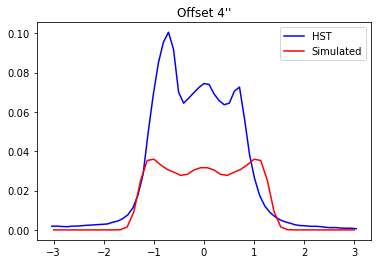

In [30]:
offset = 4

start_x = 59 + 41 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) + 40 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
end_x = 59 + 41 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) - 40 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
start_y = 60 + 40 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) - 41 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
end_y = 60 + 40 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) + 41 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
y_array = skimage.measure.profile_line(hst_image[920 : 1030, 1400 : 1525], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array) - 1) / 2 * 0.1013, -(len(y_array) - 1) / 2 * 0.1013, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float))), color = 'blue', label = "HST")
plt.title("Offset 4\'\'")

y_array = skimage.measure.profile_line(astropy_conv, [60 + 3 * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], [60 - 3 * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], linewidth = 1)
x_array = np.linspace(-3, 3, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(astropy_conv[int(resolution / 2)], dtype = float))), color = 'red', label = "Simulated")
plt.legend()

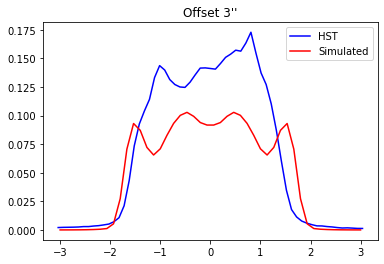

In [31]:
offset = 3

start_x = 59 + 41 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) + 40 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
end_x = 59 + 41 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) - 40 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
start_y = 60 + 40 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) - 41 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
end_y = 60 + 40 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) + 41 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
y_array = skimage.measure.profile_line(hst_image[920 : 1030, 1400 : 1525], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array) - 1) / 2 * 0.1013, -(len(y_array) - 1) / 2 * 0.1013, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float))), color = 'blue', label = "HST")
plt.title("Offset 3\'\'")

y_array = skimage.measure.profile_line(astropy_conv, [60 + 3 * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], [60 - 3 * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], linewidth = 1)
x_array = np.linspace(-3, 3, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(astropy_conv[int(resolution / 2)], dtype = float))), color = 'red', label = "Simulated")
plt.legend()

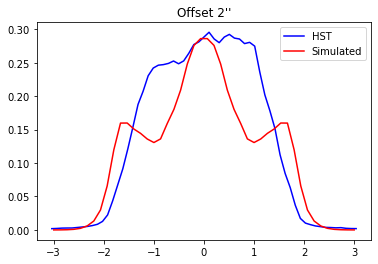

In [32]:
offset = 2

start_x = 59 + 41 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) + 40 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
end_x = 59 + 41 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) - 40 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
start_y = 60 + 40 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) - 41 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
end_y = 60 + 40 * offset / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2)) + 41 * 3 / (0.1013 * np.sqrt(40 ** 2 + 41 ** 2))
y_array = skimage.measure.profile_line(hst_image[920 : 1030, 1400 : 1525], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array) - 1) / 2 * 0.1013, -(len(y_array) - 1) / 2 * 0.1013, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float))), color = 'blue', label = "HST")
plt.title("Offset 2\'\'")

y_array = skimage.measure.profile_line(astropy_conv, [60 + 3 * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], [60 - 3 * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], linewidth = 1)
x_array = np.linspace(-3, 3, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(astropy_conv[int(resolution / 2)], dtype = float))), color = 'red', label = "Simulated")
plt.legend()

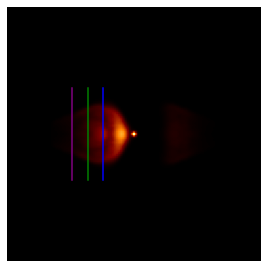

In [33]:
f = plt.figure(figsize = (10, 5))
ax = f.add_subplot(121, aspect = 1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
# plt.title("Image")
plt.imshow(astropy_conv, cmap = 'afmhot')
plt.gca().set_aspect('equal')
plt.axis('off')
offset = 4
plt.plot([60 - offset * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], [60 + 3 * resolution / (angularSize * 2), 60 - 3 * resolution / (angularSize * 2)], color = "purple")
offset = 3
plt.plot([60 - offset * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], [60 + 3 * resolution / (angularSize * 2), 60 - 3 * resolution / (angularSize * 2)], color = "green")
offset = 2
plt.plot([60 - offset * resolution / (angularSize * 2), 60 - offset * resolution / (angularSize * 2)], [60 + 3 * resolution / (angularSize * 2), 60 - 3 * resolution / (angularSize * 2)], color = "blue")

In [34]:
# END